In [4]:
import time
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd

from sklearn import set_config
set_config(display='diagram')

from sklearn.utils import shuffle

from sklearn.compose import make_column_selector
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor

from sklearn.model_selection import cross_validate, cross_val_predict

In [ ]:
# from sklearn.datasets import fetch_openml
# df = fetch_openml(name="house_prices", as_frame=True)

Загружаем датасет

In [5]:
X_hist = pd.read_csv('train.csv')

In [6]:
X_hist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Создаём селекторы столбцов датасета по типу данных

In [7]:
cat_selector = make_column_selector(dtype_include=object)
num_selector = make_column_selector(dtype_include=np.number)

Заменяем нулы на дефолтные значения

In [8]:
for col in cat_selector(X_hist): X_hist[col].fillna('NA', inplace=True)
for col in num_selector(X_hist): X_hist[col].fillna(0, inplace=True)

In [9]:
X_hist

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NA,Reg,Lvl,AllPub,...,0,NA,MnPrv,NA,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NA,Reg,Lvl,AllPub,...,0,NA,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,4,2010,WD,Normal,142125


Столюец SalePrice целевой, остальные - фичи

In [10]:
Y_sel = np.log(X_hist['SalePrice'])
X_sel = X_hist.loc[:, ~X_hist.columns.isin(['SalePrice'])]

Чтобы оценить важность фич с помощью RandomForestRegressor, надо перевести все категориальные фичи в числовые

In [ ]:
le = LabelEncoder()
cat_cols = cat_selector(X_sel)
X_sel[cat_cols] = X_sel[cat_cols].apply(lambda col: le.fit_transform(col))

In [12]:
X_sel

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,3,65.0,8450,1,1,3,3,0,...,0,0,3,4,1,0,2,2008,8,4
1,2,20,3,80.0,9600,1,1,3,3,0,...,0,0,3,4,1,0,5,2007,8,4
2,3,60,3,68.0,11250,1,1,0,3,0,...,0,0,3,4,1,0,9,2008,8,4
3,4,70,3,60.0,9550,1,1,0,3,0,...,0,0,3,4,1,0,2,2006,8,0
4,5,60,3,84.0,14260,1,1,0,3,0,...,0,0,3,4,1,0,12,2008,8,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,3,62.0,7917,1,1,3,3,0,...,0,0,3,4,1,0,8,2007,8,4
1456,1457,20,3,85.0,13175,1,1,3,3,0,...,0,0,3,2,1,0,2,2010,8,4
1457,1458,70,3,66.0,9042,1,1,3,3,0,...,0,0,3,0,3,2500,5,2010,8,4
1458,1459,20,3,68.0,9717,1,1,3,3,0,...,0,0,3,4,1,0,4,2010,8,4


Проводим оценку фич с помощью RandomForestRegressor

In [13]:
clf = RandomForestRegressor().fit(X_sel, Y_sel)

In [14]:
feat = dict(sorted(dict(zip(X_sel.columns, clf.feature_importances_)).items(),
                   key=lambda x: x[1], reverse=False))

In [15]:
feat

{'Utilities': 0.0,
 'Street': 3.307940967146473e-05,
 'PoolQC': 5.479602788327088e-05,
 '3SsnPorch': 7.539888797873061e-05,
 'MiscFeature': 8.632276571775593e-05,
 'MiscVal': 9.684433039134274e-05,
 'PoolArea': 0.00010951742152127519,
 'RoofMatl': 0.00015562386384812896,
 'Heating': 0.00015629011076622227,
 'Condition2': 0.00017694168022792516,
 'LowQualFinSF': 0.0001999910396018854,
 'BsmtHalfBath': 0.000272120746649696,
 'BsmtFinSF2': 0.00029107009735992556,
 'BsmtFinType2': 0.00035194002132226467,
 'BldgType': 0.00040445839559986364,
 'SaleType': 0.0004945770741143257,
 'ScreenPorch': 0.000541129348426621,
 'Alley': 0.0005498532637480319,
 'RoofStyle': 0.0006118247638219406,
 'MasVnrType': 0.0006145665065285766,
 'Electrical': 0.0006430466625069995,
 'LotConfig': 0.0006615447011780819,
 'Condition1': 0.0006642032992416589,
 'Foundation': 0.0006868417910917972,
 'Functional': 0.0008286834985410554,
 'LandSlope': 0.0008342030254799194,
 'GarageQual': 0.0008417317983469201,
 'Fireplace

''

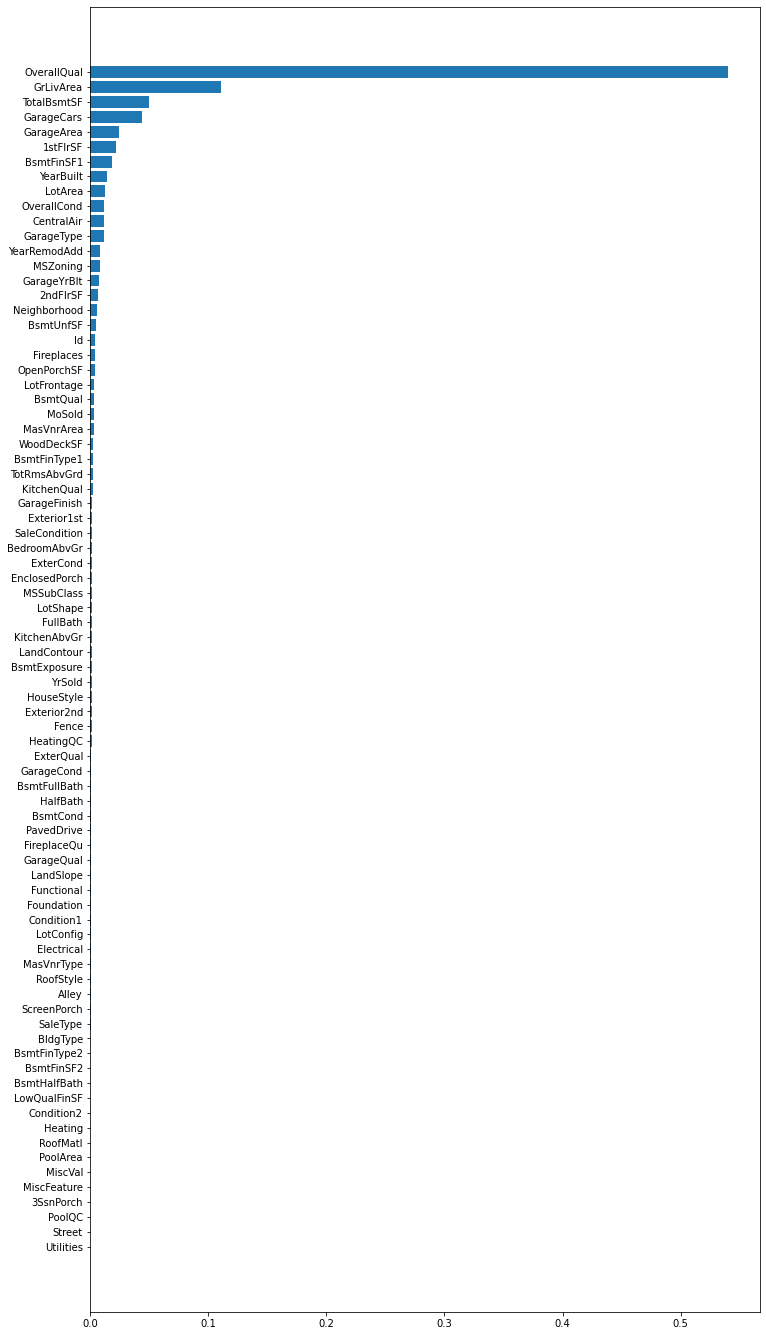

In [16]:
plt.figure(figsize=(12, 24))
plt.barh(np.arange(len(feat)), feat.values())
plt.yticks(np.arange(len(feat)),feat.keys())
''

Отбираем фичи с весом более 1%

In [20]:
features = dict(filter(lambda x: x[1] > 0.01, feat.items())).keys()
features

dict_keys(['GarageType', 'CentralAir', 'OverallCond', 'LotArea', 'YearBuilt', 'BsmtFinSF1', '1stFlrSF', 'GarageArea', 'GarageCars', 'TotalBsmtSF', 'GrLivArea', 'OverallQual'])

In [18]:
X = X_hist[features]
y = Y_sel
X, y = shuffle(X, y, random_state=0)

Собираем стекинг из трёх моделей с предварительной обработкой данных

Для деревье оставляем фичи как есть

Для линейных моделей проводим стандартизацию числовых значений

In [19]:
cat_tree_processor = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
num_tree_processor = SimpleImputer(strategy="mean", add_indicator=True)

tree_preprocessor = make_column_transformer((num_tree_processor, num_selector),
                                            (cat_tree_processor, cat_selector))
tree_preprocessor

ColumnTransformer(transformers=[('simpleimputer',
                                 SimpleImputer(add_indicator=True),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fd74fcd2d68>),
                                ('ordinalencoder',
                                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                                unknown_value=-1),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fd74fcd2be0>)])

In [21]:
cat_linear_processor = OneHotEncoder(handle_unknown="ignore")
num_linear_processor = make_pipeline(StandardScaler(), SimpleImputer(strategy="mean", add_indicator=True))

linear_preprocessor = make_column_transformer((num_linear_processor, num_selector),
                                              (cat_linear_processor, cat_selector))
linear_preprocessor

ColumnTransformer(transformers=[('pipeline',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler()),
                                                 ('simpleimputer',
                                                  SimpleImputer(add_indicator=True))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fd74fcd2d68>),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fd74fcd2be0>)])

In [22]:
lasso_pipeline = make_pipeline(linear_preprocessor, LassoCV())
lasso_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('simpleimputer',
                                                                   SimpleImputer(add_indicator=True))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd74fcd2d68>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd74fcd2be0>)])),
                ('lassocv', LassoCV())])

In [23]:
rf_pipeline = make_pipeline(tree_preprocessor, RandomForestRegressor(random_state=42))
rf_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('simpleimputer',
                                                  SimpleImputer(add_indicator=True),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd74fcd2d68>),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd74fcd2be0>)])),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

In [24]:
gbr_pipeline = make_pipeline(tree_preprocessor, GradientBoostingRegressor(random_state=0))
gbr_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('simpleimputer',
                                                  SimpleImputer(add_indicator=True),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd74fcd2d68>),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd74fcd2be0>)])),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(random_state=0))])

In [25]:
estimators = [('Random Forest', rf_pipeline),
              ('Lasso', lasso_pipeline),
              ('Gradient Boosting', gbr_pipeline)]

stacking_regressor = StackingRegressor(estimators=estimators, final_estimator=RidgeCV())
stacking_regressor

StackingRegressor(estimators=[('Random Forest',
                               Pipeline(steps=[('columntransformer',
                                                ColumnTransformer(transformers=[('simpleimputer',
                                                                                 SimpleImputer(add_indicator=True),
                                                                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fd74fcd2d68>),
                                                                                ('ordinalencoder',
                                                                                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                unknown_value=-1),
                                                                                 <sklearn.compose...
                                                                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fd74fcd2d68>),
                                                                                ('ordinalencoder',
                                                                                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                unknown_value=-1),
                                                                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fd74fcd2be0>)])),
                                               ('gradientboostingregressor',
                                                GradientBoostingRegressor(random_state=0))]))],
                  final_estimator=RidgeCV(alphas=array([ 0.1,  1. , 10. ])))

Функция для рисования диаграммы эффективности предсказаний каждой модели

In [26]:
def plot_regression_results(ax, y_true, y_pred, title, scores, elapsed_time):
    """Scatter plot of the predicted vs true targets."""
    ax.plot([y_true.min(), y_true.max()],
            [y_true.min(), y_true.max()],
            '--r', linewidth=2)
    ax.scatter(y_true, y_pred, alpha=0.2)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.set_xlim([y_true.min(), y_true.max()])
    ax.set_ylim([y_true.min(), y_true.max()])
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    extra = plt.Rectangle((0, 0), 0, 0, fc="w", fill=False,
                          edgecolor='none', linewidth=0)
    ax.legend([extra], [scores], loc='upper left')
    title = title + '\n Evaluation in {:.2f} seconds'.format(elapsed_time)
    ax.set_title(title)


Проводим обучение моделей в стеке и рисуем сводную диаграмму

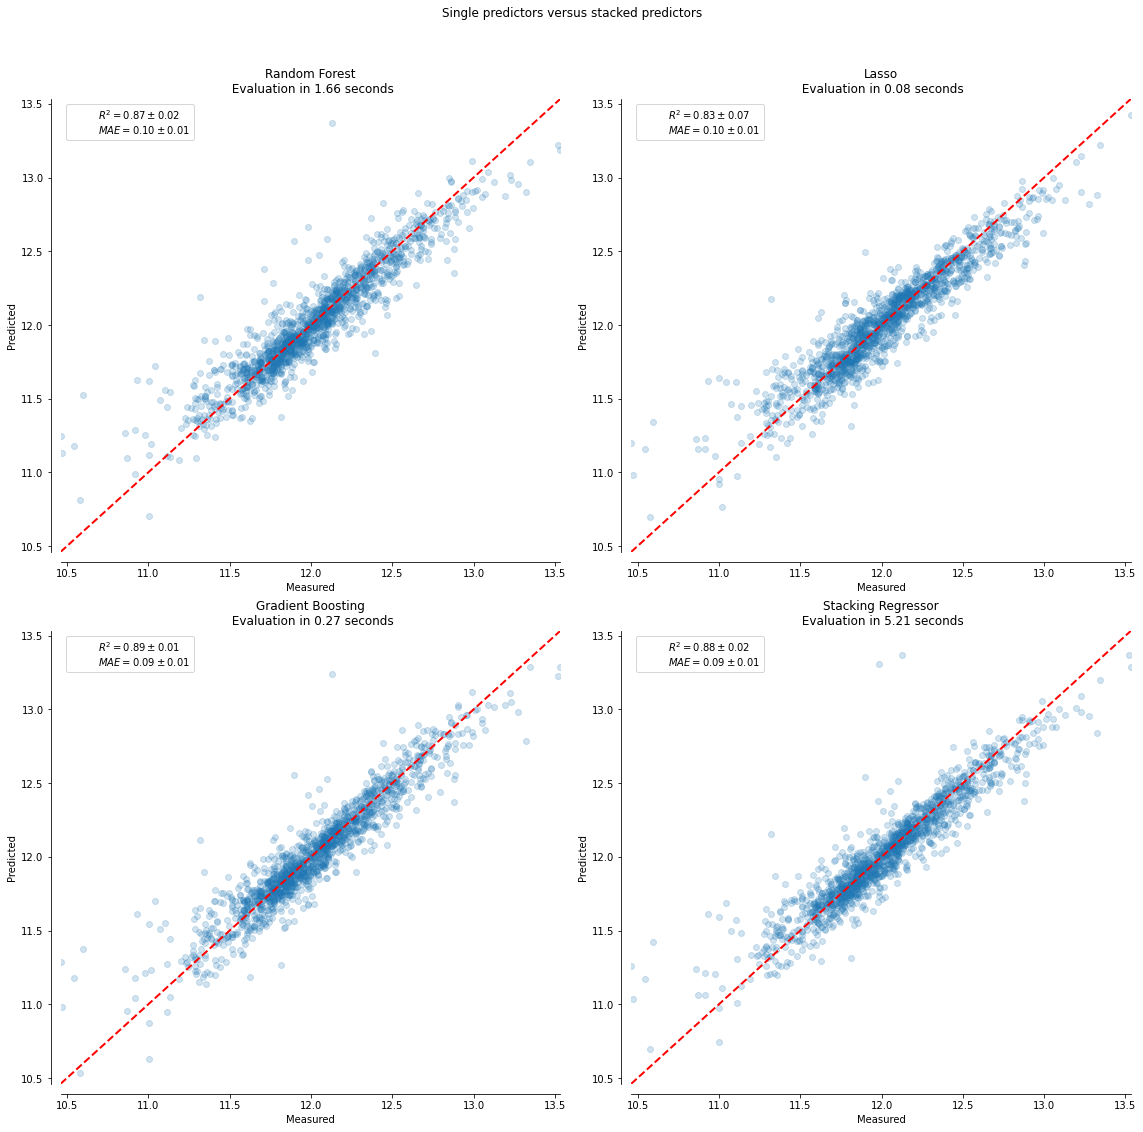

In [27]:
fig, axs = plt.subplots(2, 2, figsize=(16, 16))
axs = np.ravel(axs)

for ax, (name, est) in zip(axs, estimators + [('Stacking Regressor',
                                               stacking_regressor)]):
    start_time = time.time()
    score = cross_validate(est, X, y,
                           scoring=['r2', 'neg_mean_absolute_error'],
                           n_jobs=-1, verbose=0)
    elapsed_time = time.time() - start_time

    y_pred = cross_val_predict(est, X, y, n_jobs=-1, verbose=0)

    plot_regression_results(
        ax, y, y_pred,
        name,
        (r'$R^2 = {:.2f} \pm {:.2f}$' + '\n' + r'$MAE={:.2f} \pm {:.2f}$')
        .format(np.mean(score['test_r2']), np.std(score['test_r2']),
                -np.mean(score['test_neg_mean_absolute_error']),
                np.std(score['test_neg_mean_absolute_error'])),
        elapsed_time)

plt.suptitle('Single predictors versus stacked predictors')
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()